
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="center">Curso: Metodos Estadisticos</p>

<p align="center"> Código Curso: 203008067 </p>

<p align="center"> Grupo: 7 </p>

 <p align="center">  Tarea 2: Aprendizaje Estadistico Supervisado </p>

 <p align="center">  Presentado por: Juan José García Sánchez </p>

<p align="center"> Código: 203008077</p>

 <p align="center"> Tutor(a): Mireya García García </p>

 <p align="center"> 27/10/2024 </p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA - UNAD </p>



# Objetivo General

### Entender la distribución y relaciones entre las variables, mediante el análisis exploratorio de datos, para su inclusión en el modelo de precios dinamicos de la empresa.

# Objetivos Especificos

### Resumir la distribución y caracteristicas del conjunto de datos, mediante el uso de tablas de frecuencia, estadisticos de tendencia central y de dispersion, para facilitar la interpretación, y usar como insumo en posteriores analisis.

### Identificar las posibles relaciones o correlaciones entre variables numericas, mediante analisis de dispersion y pruebas estadisticas, para establecer su posible relevancia en el costo del transporte.

### Demostrar la presencia (o ausencia) de relaciones significativas entre variables numericas y categoricas, Mediante las pruebas estadisticas chi-cuadrado y ANOVA, para validar el uso de las variables en el model de precios. 

# Importar librerias

In [276]:
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, binarize, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
formato = "{:.3f}"
pd.options.display.float_format = formato.format

# Funciones para Metricas:

Se definen varias funciones de conveniencia para los calculos de las métricas de modelos, y para los calculos de las pruebas estadisticas.

In [281]:
def mostrar_parametros(variables, modelo, valores_t, valores_p, nombre_parametros="parametros"):
    """
    Contruir un dataframe para mostrar los resultados de un modelo de regresion.
    muestra los nombres de las variables, valores de parametros estimados,
    valores t y valores p.
    """
    summ = pd.DataFrame(
        {"variables":[*variables, "intercepto"], 
        "parametros":[*modelo.coef_, modelo.intercept_],
        "valores t": valores_t,
        "valores_p": valores_p
        })

    return summ
        
def mostrar_metricas(y_real, y_predicho, decimales = 4, num_predictores=None):
    """
    Mostrar un tabla con resultados  de medidas de resumen de ajuste de
    modelos: calcula el MSE, RMSE, R2, MAE, R2_aj
    """ 
   # calculo del R cuadrado
    r2 = metrics.r2_score(y_real, y_predicho)
    
    summ = [ f"R2    : {r2:.{decimales}f}", ]

    # calculo R2 cuadrado ajustado, si se pasa un numero de predictores
    if num_predictores is not None:
        n = y_real.size
        
        r2_adj = 1 - ( (1 - r2) * (n - 1) ) / (n - num_predictores - 1) 

        summ.append(f"R2_adj: {r2_adj:.{decimales}f}")

    # Calculo de metricas MSE, RMSE, MAE
    
    mse = metrics.mean_squared_error(y_real, y_predicho)
    
    rmse = np.sqrt(mse)
 
    mae =  metrics.mean_absolute_error(y_real, y_predicho)
    
    summ.extend(
        (
        f"MSE   : {mse:.{decimales}f}",
        f"RMSE  : {rmse:.{decimales}f}",
        f"MAE   : {mae:.{decimales}f}",
        ))

    return "\n".join(summ)
    
    

def calcular_valor_t(X, y_real, y_pred, estadistico_estimado, estadistico_esperado):
    """
    Calcular valores t, comparando los valores estimados de un estadistico vs los valores
    esperados. se calculan los valores t y lo valores p correspondientes.
    """

    # obtener cantidad de puntos de datos
    n = y_real.shape[0]

    # calculo de resiudos, despues de haber entrenado un modelo 
    residuos = y_real - y_pred

    # Calculo de la desviacion estandar de los residuos. 
    # grado de libertad n-2 por ser un modelo regresion
    
    SC = residuos ** 2 

    std_residuos = np.sqrt(SC.sum()/(n - 2))

    # calculo de la desviacion estandar de las caracteriscas

    std_X = X.values.std()

    # calculo del error estandar. se invierte para usarlo directamente despues

    inv_std_error = (np.sqrt(n - 1)/std_residuos) * (std_X)

    # calculo del estadisticos t y p,  con t = (m_estimado - m_esperado)/error_estandar
    valor_t = (estadistico_estimado - estadistico_esperado) * inv_std_error

    valor_p = stats.t.sf(np.abs(valor_t), df= n - 2) * 2

    return valor_t, valor_p


# Funciones para Visualización:

Se definine varias funciones para graficar las predicciones de los modelos, y visualizar metricas

In [289]:
def grafico_linear_simple(x_entre, y_entre, x_prueba, y_prueba, modelo, titulo, titulo_x, titulo_y):
    plt.scatter(x_entre, y_entre, color="c", label="entrenamiento")
    
    plt.scatter(x_prueba, y_prueba, color="r", label="prueba")

    x_reg = np.linspace(np.min(x_entre), np.max(x_entre), 300).reshape(-1, 1)
    y_reg = modelo.predict(x_reg)
    
    plt.plot(x_reg, y_reg, "k--", label="linea regresión")

    plt.title(titulo)

    # Etiquetas de los ejes (opcional)
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.legend()

    # Mostrar el gráfico
    plt.show()


def grafico_real_vs_predicho(y_prueba, y_prueba_pred, titulo, titulo_x, titulo_y):
    linea = np.linspace(np.min(y_prueba_pred), np.max(y_prueba_pred), 300)
    
    plt.plot(linea, linea, color='k', linestyle='--', label='y = x')
    
    plt.scatter(y_prueba, y_prueba_pred, color="c")
    
    plt.title(titulo)
    
    # Etiquetas de los ejes (opcional)
    plt.xlabel(titulo_x)
    plt.ylabel(titulo_y)
    plt.legend()
    
    # Mostrar el gráfico
    plt.show()

def grafico_residuos(y_real, y_predicho, titulo, titulo_x, titulo_y, color="g"):
    """
    Calcular y graficar residuos de un modelo de regresion versus los valores
    predichos.
    """
    fig = plt.figure()

    ax = fig.add_subplot()

    residuos = y_real - y_predicho
    
    ax.scatter(y_predicho, residuos, color=color, alpha=0.6)

    ax.axhline(y=0, color="k", linestyle="--")

    ax.set_title(titulo)

    ax.set_xlabel(titulo_x)

    ax.set_ylabel(titulo_y)

    plt.show()
    

def matriz_confusion(y_real, y_predicho):
    matriz = metrics.confusion_matrix(y_real, y_predicho)
    
    heatmap(matriz, "Matriz Confusion", "d")
    
    ax = plt.gca()
    
    ax.set_xlabel("Valor Predicho")
    
    ax.set_ylabel("Valor Real")


def heatmap(matriz, titulo, formato=".2f", tamaño = (4, 4), mapa="Reds"):
    """
    Presentar un vision grafica de una matrix, com un mapa de calor.
    """
    plt.figure(figsize=tamaño)
    
    sns.heatmap(matriz, annot=True, cmap=mapa, fmt=formato)
    
    plt.title(titulo)


# Variables:

Las siguientes clases definen enumeraciones. Su función es simplemente contener constantes en un solo conjunto, para evitar los errores en el codigo.

In [290]:
# Variables categoricas del dataset
class Categ(Enum):
    locacion = "Location_Category"
    lealtad = "Customer_Loyalty_Status"
    tiempo_viaje = "Time_of_Booking"
    vehiculo = "Vehicle_Type"

# Variables numericas del dataset
class Num(Enum):
    viajes_pasados = "Number_of_Past_Rides"
    puntaje_promedio = "Average_Ratings"
    pasajeros = "Number_of_Riders" 	
    conductores = "Number_of_Drivers"
    duracion_esperada = "Expected_Ride_Duration"
    costo_historico = "Historical_Cost_of_Ride"

# Limpieza de datos

Se realiza el cargue de los datos, y se eliminan los datos nulos: 

In [4]:
# Carga los datos en un dataframe de Pandas

#limpiado de datos, el archivo csv debe estar en el mismo directorio
df_crudo = pd.read_csv('Anexo 1- Base de Datos dynamic_pricing.csv')

df_crudo.drop_duplicates()

df_modelos = df_crudo.dropna()

# Pruebas estadisticas de regresiones:

La prueba estadistica por excelencia para probar la significancia de las regresiones halladas es la prueba *t - student*. Esta prueba se usa para probar si existen diferencias significativas entre dos poblaciones, usando algún estadistico para la prueba. Normalmente se usa las medias poblacionales, pero en este caso se usan los valores de los parametros de los modelos (pendientes en regresión lineal, pesos en regresion logistica). Las ecuaciones relevantes para la prueba son las siguientes:

- calculo valor t:

$$ t_s = \frac{b_{estimado} - b_{esperado}}{ET} $$ 

- calculo del error estandar:

$$ ET = \frac{s_{r}}{s_x * \sqrt{n - 1}} $$

- calculo Residuos:

$$ r = y_{real} - y_{predicho}$$

- desviación estandar residuos:

  $$ s_r = \sqrt{\frac{\sum^{n}_{i = 0}{r_i^2}}{n - 2}}$$

- desviación estandar :

$$ s_x = \sqrt{\frac{\sum^{n}_{i = 0}{x_i - \bar{x}}}{n - 1}}$$

En las anteriores ecuaciones: $n$ es el total de puntos de datos, $b_{estimado}$ es el parametro calculado y $b_{esperado}$ es el valor esperado para la hipotesis nula; $\bar{x}$ es el promedio calculado para la variable independiente; $y$ son los valores de la variable de respuesta. 

Se usan las siguientes hipotesis para realizar la prueba t - student, sobre cada uno de los parametros:

$$ H_0: b = 0 $$
$$ H_1: b \neq 0 $$

La hipotesis nula indica que no hay correlación entre la variable independiente y dependiente, y que los coeficientes esperados deberian ser cero. La hipotesis alternativa indica que si existe correlación, y que el coeficiente debe ser diferente de cero. Los valores $P$ se pueden calcular a partir de los valores $t$, teniendo en cuenta que los grados de libertad son de $n - 2$


# Regresion Lineal Simple

Para la regresión lineal se esta empleado la interface `LinearRegression` del paquete sklearn. Se hace una separación previa de los datos en entrenamiento y prueba, en proporciones $30 \% - 70 \%$. Se extraen en variables especificamente los campos que se van a usar para las diversas regresiones lineales.

In [112]:
from sklearn.linear_model import LinearRegression

In [221]:
# Dividir los datos en conjuntos de entrenamiento y prueba (70% entrenamiento y 30% prueba)

X_entre_lin, X_prueba_lin, y_entre_lin, y_prueba_lin = train_test_split(df_modelos,
                                                        df_modelos[Num.costo_historico.value], 
                                                        train_size=0.7,
                                                       random_state=600) 

viajes_entre = X_entre_lin[[Num.viajes_pasados.value]]
duracion_entre = X_entre_lin[[Num.duracion_esperada.value]]

viajes_prueba = X_prueba_lin[[Num.viajes_pasados.value]]
duracion_prueba = X_prueba_lin[[Num.duracion_esperada.value]]


## Costos Historico vs. Cantidad Viajes Pasados

### Ajuste del modelo:

In [222]:
#se crea el objeto de regresión lineal
modlin_viajes = LinearRegression()

# el modelo usando los datos de entrenamiento
modlin_viajes.fit(viajes_entre, y_entre_lin)

LinearRegression()

In [225]:
y_entre_pred = modlin_viajes.predict(viajes_entre)
y_prueba_pred = modlin_viajes.predict(viajes_prueba)

### Visualización:

C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


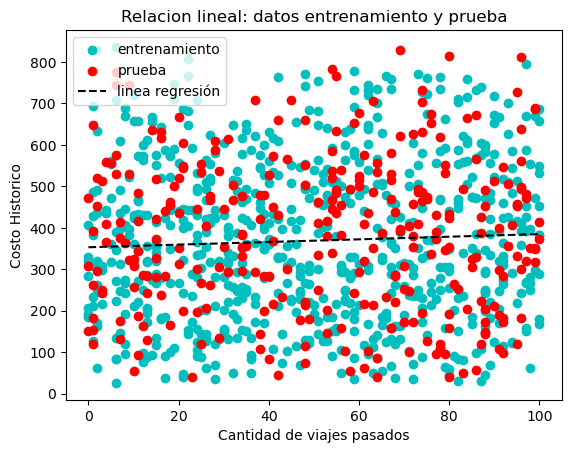

In [280]:
grafico_linear_simple(viajes_entre, y_entre_lin, 
                      viajes_prueba, y_prueba_lin, 
                      modlin_viajes,
                      'Relacion lineal: datos entrenamiento y prueba', 
                      'Cantidad de viajes pasados',
                      'Costo Historico'
                     )

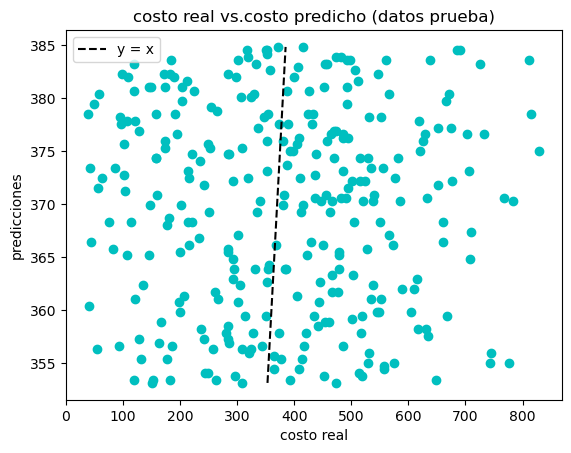

In [282]:
grafico_real_vs_predicho(y_prueba_lin, y_prueba_pred, 
                         'costo real vs.costo predicho (datos prueba)',
                         'costo real',
                         "predicciones"
                        )

### Metricas y Parametros:

In [275]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=1))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=1))

metricas entrenamiento:
R2    : 0.0024
R2_adj: 0.0009
MSE   : 35665.2333
RMSE  : 188.8524
MAE   : 158.8371
metricas prueba:
R2    : -0.0067
R2_adj: -0.0100
MSE   : 33338.8161
RMSE  : 182.5892
MAE   : 151.8171


In [265]:
valores_t, valores_p = calcular_valor_t(viajes_prueba, y_prueba_lin, y_prueba_pred, np.append(modlin_viajes.coef_, modlin_viajes.intercept_), 0)

mostrar_parametros([Num.viajes_pasados.value], modlin_viajes, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Number_of_Past_Rides,0.317,0.895,0.372
1,intercepto,353.132,996.131,0.000


### Prueba del Modelo

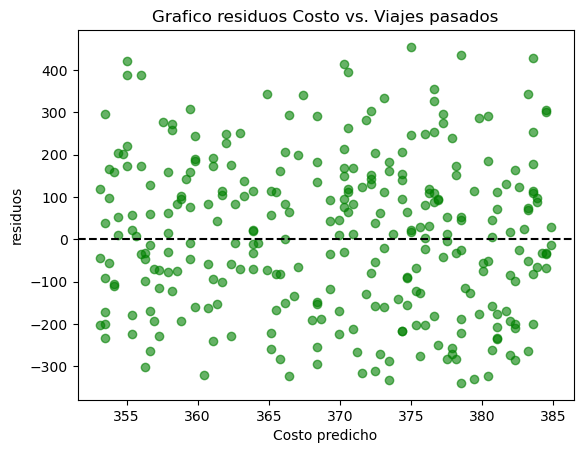

In [283]:
grafico_residuos(y_prueba_lin, y_prueba_pred, 
                 "Grafico residuos Costo vs. Viajes pasados", 
                 "Costo predicho", 
                 "residuos")

## Costos Historico vs. Duración Esperada del Viaje

### Ajuste del modelo:

In [156]:
#se crea el objeto de regresión lineal
modlin_duracion = LinearRegression()

# el modelo usando los datos de entrenamiento
modlin_duracion.fit(duracion_entre, y_entre_lin)

LinearRegression()

In [286]:
y_entre_pred  = modlin_duracion.predict(duracion_entre)
y_prueba_pred = modlin_duracion.predict(duracion_prueba)

### Visualización:

C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


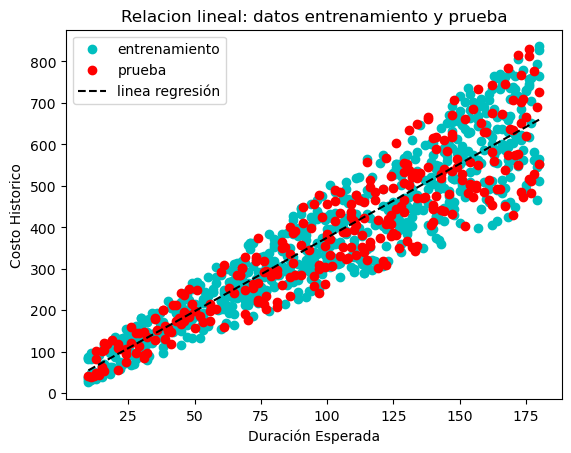

In [284]:
grafico_linear_simple(duracion_entre, y_entre_lin, 
                      duracion_prueba, y_prueba_lin,
                      modlin_duracion,
                      'Relacion lineal: datos entrenamiento y prueba',
                      'Duración Esperada',
                      'Costo Historico')

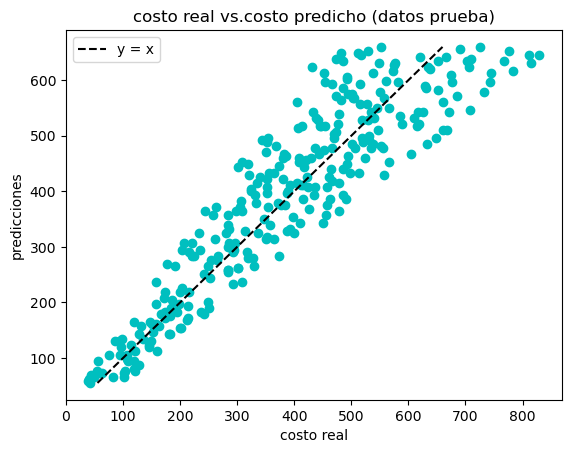

In [287]:
grafico_real_vs_predicho(y_prueba_lin, y_prueba_pred,
                         'costo real vs.costo predicho (datos prueba)',
                         'costo real',
                         'predicciones')

### Metricas y Parametros:

In [161]:
print("metricas entrenamiento:")
mostrar_metricas(y_entre_lin, y_entre_pred)

print("metricas prueba:")
mostrar_metricas(y_prueba_lin, y_prueba_pred)

metricas entrenamiento:
R2  : 0.8679
MSE : 4723.3977
RMSE: 68.7270
MAE : 54.5048
metricas prueba:
R2  : 0.8406
MSE : 5280.1836
RMSE: 72.6649
MAE : 57.5641


In [265]:
valores_t, valores_p = calcular_valor_t(viajes_prueba, y_prueba_lin, y_prueba_pred, np.append(modlin_viajes.coef_, modlin_viajes.intercept_), 0)

mostrar_parametros([Num.viajes_pasados.value], modlin_viajes, valores_t, valores_p)

,variables,parametros,valores t,valores_p
0,Number_of_Past_Rides,0.317,0.895,0.372
1,intercepto,353.132,996.131,0.000


### Prueba del Modelo

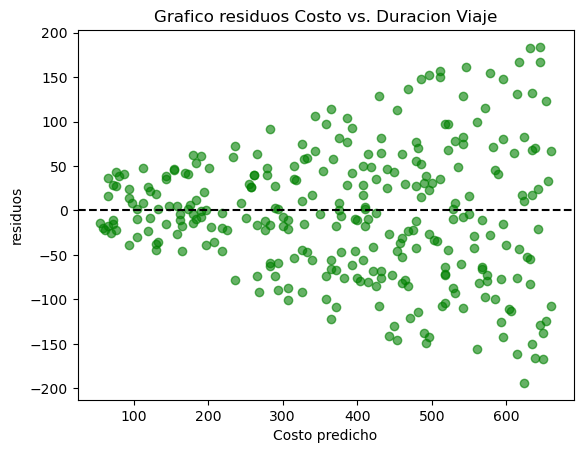

In [163]:
grafico_residuos(y_prueba_lin, y_prueba_pred, 
                 "Grafico residuos Costo vs. Duracion Viaje", 
                 "Costo predicho", 
                 "residuos")

# Regresion Lineal Multiple

### Ajuste del modelo:

In [135]:
caracteristicas = [Num.pasajeros.value, Num.conductores.value, Num.viajes_pasados.value, Num.duracion_esperada.value]

modmul = LinearRegression()

modmul.fit(X_entre_lin[caracteristicas], y_entre_lin)

LinearRegression()

In [137]:
y_entre_pred = modmul.predict(X_entre_lin[caracteristicas])
y_prueba_pred = modmul.predict(X_prueba_lin[caracteristicas])

### Visualización:

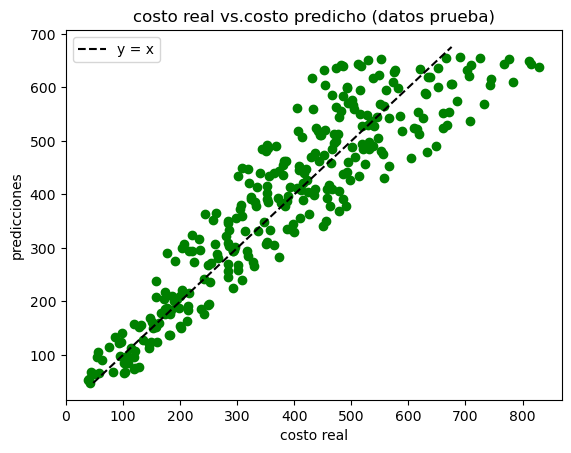

In [23]:
linea = np.linspace(np.min(y_prueba_pred), np.max(y_entre_pred), 300)
plt.plot(linea, linea, color='k', linestyle='--', label='y = x')

plt.scatter(y_prueba_lin, y_prueba_pred, color="g")

plt.title('costo real vs.costo predicho (datos prueba)')

# Etiquetas de los ejes (opcional)
plt.xlabel('costo real')
plt.ylabel('predicciones')
plt.legend()

# Mostrar el gráfico
plt.show()

### Metricas y Parametros:

In [288]:
print("metricas entrenamiento:")
print(mostrar_metricas(y_entre_lin, y_entre_pred, num_predictores=1))

print("metricas prueba:")
print(mostrar_metricas(y_prueba_lin, y_prueba_pred, num_predictores=1))

metricas entrenamiento:
R2    : 0.8679
R2_adj: 0.8677
MSE   : 4723.3977
RMSE  : 68.7270
MAE   : 54.5048
metricas prueba:
R2    : 0.8406
R2_adj: 0.8400
MSE   : 5280.1836
RMSE  : 72.6649
MAE   : 57.5641


In [140]:
valores_t, valores_p = calcular_valor_t(X_prueba_lin[caracteristicas], y_prueba_lin, y_prueba_pred, modmul.coef_, 0)

In [142]:
for p in valores_p:
    print(f"{p:0.3f}")

0.972
0.088
0.982
0.000


## Prueba del Modelo

# Regresion Logistica

### Ajuste del modelo:

In [173]:
from sklearn.linear_model import LogisticRegression

In [195]:
caract_log = [Categ.locacion.value, Categ.lealtad.value, Categ.tiempo_viaje.value, Categ.vehiculo.value]

prep = ColumnTransformer([
    ('codificado_nominal', OneHotEncoder(), [Categ.locacion.value, Categ.tiempo_viaje.value]),
    ('codificado_ordinal', OrdinalEncoder(), [Categ.lealtad.value, Categ.vehiculo.value]),
                         ],
    remainder= 'drop')

calidad = binarize(df_modelos[[Num.puntaje_promedio.value]], threshold=4).ravel()

X_entre_log, X_prueba_log, calidad_entre, calidad_prueba = train_test_split(df_modelos[caract_log],
                                                        calidad, 
                                                        train_size=0.7,
                                                       random_state=600) 

In [196]:
#construyendo las variables para el nivel de produtividad (productividad alta: 1; productividad baja: 0)

modlog = Pipeline([
    ("preprocesamiento", prep),
    ("logistico", LogisticRegression())
])

modlog.fit(X_entre_log, calidad_entre)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('codificado_nominal',
                                                  OneHotEncoder(),
                                                  ['Location_Category',
                                                   'Time_of_Booking']),
                                                 ('codificado_ordinal',
                                                  OrdinalEncoder(),
                                                  ['Customer_Loyalty_Status',
                                                   'Vehicle_Type'])])),
                ('logistico', LogisticRegression())])

In [212]:
#coeficientes
modlog.named_steps["preprocesamiento"]["codificado_nominal"]

OneHotEncoder()

In [231]:
radios_odd = np.exp(modlog.named_steps["logistico"].coef_)

In [235]:
np.append(radios_odd, np.exp(modlog.named_steps["logistico"].intercept_))

array([0.91819475, 1.02475614, 1.05345742, 1.16754435, 0.72113309,
       1.27038497, 0.92671921, 0.95854057, 0.93677528, 2.36208238])

In [199]:
calidad_entre_pred = modlog.predict(X_entre_log)
calidad_prueba_pred = modlog.predict(X_prueba_log)

### Visualización:

### Metricas y Parametros:

In [200]:
acc_entre = metrics.accuracy_score(calidad_entre, calidad_entre_pred)
acc_prueba = metrics.accuracy_score(calidad_prueba, calidad_prueba_pred)

print(f"exactitud entrenamiento: {acc_entre:0.3f}", )
print(f"exactitud prueba: {acc_prueba:0.3f}")

exactitud entrenamiento: 0.683
exactitud prueba: 0.680


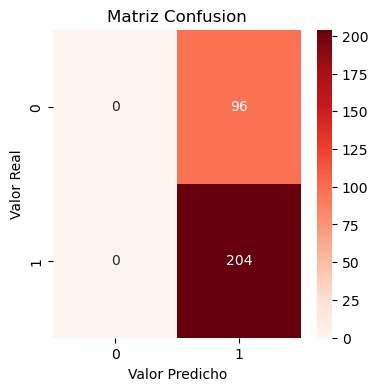

In [201]:
matriz_confusion(calidad_prueba, calidad_prueba_pred)

## Prueba del Modelo

In [152]:
print(metrics.classification_report(calidad_prueba, calidad_prueba_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.68      1.00      0.81       204

    accuracy                           0.68       300
   macro avg       0.34      0.50      0.40       300
weighted avg       0.46      0.68      0.55       300



C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\frajg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


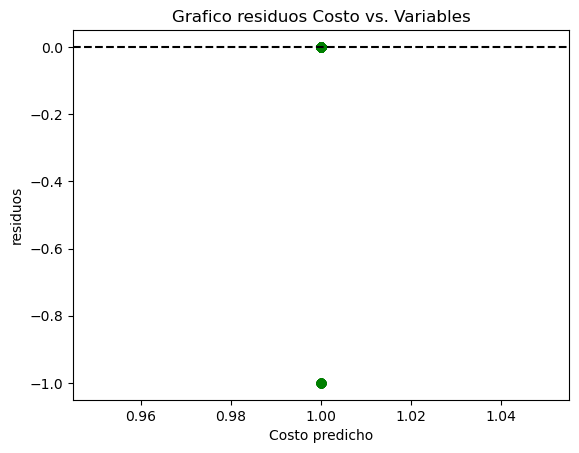

In [204]:
grafico_residuos(calidad_prueba, calidad_prueba_pred, "Grafico residuos Costo vs. Variables", "Costo predicho", "residuos")

##### Analisis

Observando la gráfica y la tabla de frecuencias se puede ver que la moda de los datos, respecto a la locación del solicitud del viaje, es la zona urbana con 346 viajes. Sin embargo, las proporciones entre las tres categorias son muy similares entre si, y todas cercanas al valor del tercio (33%) que sugeriría la probabilidad. Esta similaridad muestra que la mayoria de la categoria urbana no es significativa. 

##### Analisis

El gráfico de caja muestra una forma simetrica, con ambos bordes de la caja siendo las calificaciones de $3.67$ y $4.63$. La minima calificación es de $3.5$, la maxima del $5.0$. Esto muestra ninguno de los usuarios piensa que el servicio es malo ($<3.5$), un $25\%$ piensa que el sevicio es mediocre ($< 3.67$), un $50\%$ de los usuarios piensan que es desde mediocre hasta bueno ( > $3.6$ y $< 4.7$), y un $25\%$ piensan que es muy bueno ($> 4.7$ ). 

el promedio de $4.26$ y la mediana de $4.27$ son muy similares entre si. La desviación estandar es de $0.43$ en puntaje. Estas observaciones muestran que el conjunto completo esta sesgado hacia puntajes altos por ser el minimo $3.5$, pero entre ese limite y el maximo de $5$ es uniforme la distribución. 

#### **Duracion Esperada del Viaje**

##### Medidas de Resumen

In [139]:
medidas_resumen(df_modelos, Num.duracion_esperada.value)

,Expected_Ride_Duration
count,1000.000000
mean,99.588000
std,49.165450
min,10.000000
25%,59.750000
50%,102.000000
75%,143.000000
max,180.000000
var,2417.241497


##### Visualización

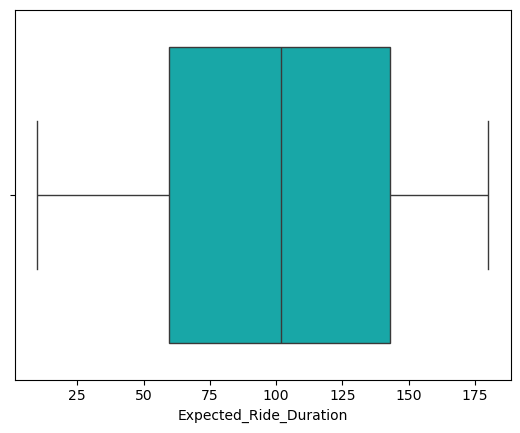

In [324]:
sns.boxplot(df_modelos[Num.duracion_esperada.value], orient="h", color="c")
plt.show()

##### Analisis:

Se asume que la duracion esperada de los viajes esta en minutos, ya que no hay información de unidades en el dataset.
La mediana de la duración esperada del viaje esta en los $102$ min, con los limites de los cuartiles $59.7$ y $143$. los valores mimino  maximo son de $10$ min y de $180$ min. el $25\%$ de los viajes dura entre $10$ minutos y $1$ hora, el $50\%$ siguiente esta entre $1$ hora y $2$ horas, $40$ min, y el ultimo $25\%$ entre las $2$ horas , $40$ min y las $3$ horas maximo.

el promedio de $99$ min es similar a la mediana de $102$, y la apariencia de la caja es simetrica, sin outliers. Esto indica que los datos estan distribuidos uniformemente sobre todo el rango de la duración.

La desviación estandar es de $49$, que es alta para la duración esperada de los viajes. Esto puede deberse a que la cubertura del servicio se da en zonas urbanas y rurales, siendo las rurales mas lejanas. Esto tambien explicaria la gran duracion del $75\%$ de los viajes en el dataset.

#### **Costo historico del Viaje**

##### Medidas de Resumen

In [142]:
medidas_resumen(df_modelos, Num.costo_historico.value)

,Historical_Cost_of_Ride
count,1000.000000
mean,372.502623
std,187.158756
min,25.993449
25%,221.365202
50%,362.019426
75%,510.497504
max,836.116419
var,35028.400030


##### Visualización

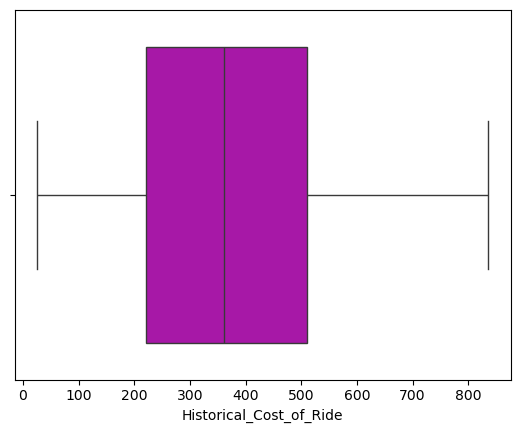

In [325]:
sns.boxplot(df_modelos[Num.costo_historico.value], orient="h", color="m")
plt.show()

##### Analisis:

No se brinda información sobre la unidad monetaria en la fuente de la información. Se van a usar unidades monetarias genericas *M* para indicar la cantidad.

La mediana del conjunto esta en $362$ M, y los limites de la caja son $221.36$ M y $510.49$ M. El costo minimo registrado es de $25.99$ M, y el maximo es de $836.12$ M.
Por la apariencia del grafico, se observa que el $50\%$ de los datos se concentran en un rango estrecho, y que la caja se desvia un poco hacia la izquierda, mostrando los datos estan sesgados hacia la derecha y tienden a valores grandes.

el promedio es de $372.5$ M, algo superior a la mediana. la desviación estandar es de $187$ M, pero la longitud estrecha de la caja muestra un relativa baja dispersión. La distancia entre los cuartiles 1,2 es de $141$, y 2,3 es de aprox. $148$ M. Esto implica que, aunque los datos esten estrictamente sesgados, hay una relativa uniformidad en su distribución. Tampoco se observan outliers en el conjunto.

# 2. Análisis Bidimensional e Inferencial.

## 1. Dispersion de pares

### Costo Historico del Viaje vs. Cantidad de pasajeros

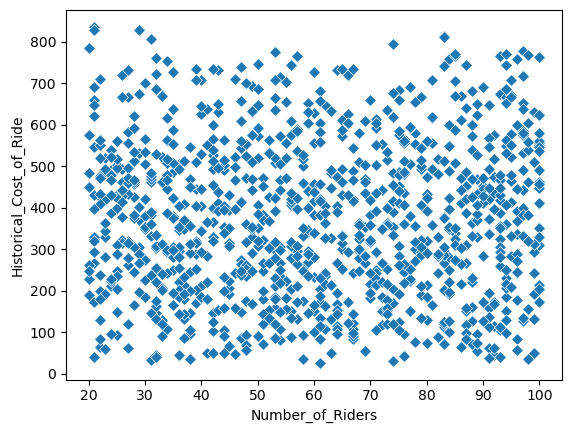

In [11]:
sns.scatterplot(df_modelos, x=Num.pasajeros.value, y=Num.costo_historico.value, marker="D")
plt.show()

### Costo Historico del Viaje vs. Puntaje Promedio 

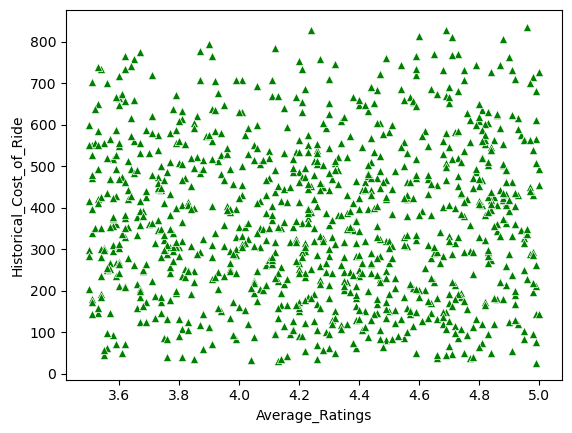

In [172]:
sns.scatterplot(df_modelos, x=Num.puntaje_promedio.value, y=Num.costo_historico.value, color="g", marker="^" )
plt.show()

### Costo Historico del Viaje vs. Duracion Esperada del Viaje 

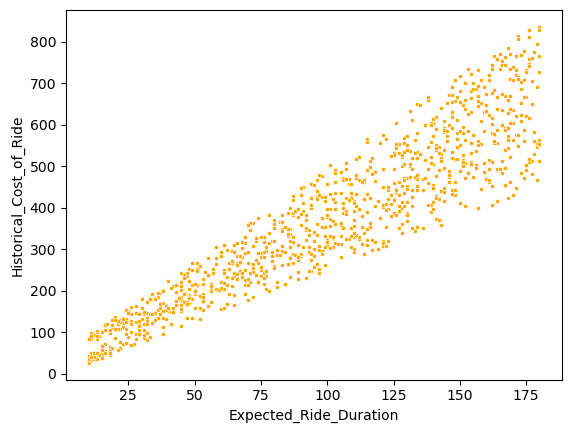

In [175]:
sns.scatterplot(df_modelos, x=Num.duracion_esperada.value, y=Num.costo_historico.value , color="orange", marker=".")
plt.show()

### Analisis de tendencias

En las dos primeras graficas, no se puede observar una dirección aparente para los puntos, y 
parecen estar distribuidos por el plano de forma aleatoria. Esto indica que posiblemente no hay relación entre **Costo historico del viaje** vs. **Cantidad de pasajeros**; y entre **Costo historico del viaje** vs. **Puntaje Promedio del viaje**.

En la tercera grafica se ve claramente una tendencia creciente entre **Costo Historico del viaje** vs. **Duración esperada del viaje**, y sugiere que la relación es lineal. Esto tiene sentido logico, ya que el costo de viaje debe aumentar con la longitud que este toma, ya que se gasta más combustible y tiempo del conductor, causando mas gasto.

## 2. Correlaciones Lineales

El siguiente fragmento de codigo calcula los coeficientes de correlación de pearson, y los valores *P* de la prueba de correlación asociada al mismo tiempoo.
Se hacen pares de las variables numericas en estudio secuencialmente, y toda la informacion se consigna en dos DataFrames: uno llamado  `corr` que contiene
los coeficientes, y otro llamado `valores_p` que contiene los valores p de las pruebas estadisticas.

In [40]:
variables_viajes = df_modelos[[Num.pasajeros.value, Num.duracion_esperada.value, Num.costo_historico.value, Num.puntaje_promedio.value]]

corr = pd.DataFrame(index=variables_viajes.columns, columns=variables_viajes.columns)

valores_p = corr.copy()

for variable_1 in variables_viajes.columns:
    coefs = []
    p_valores = []
 
    for variable_2 in variables_viajes.columns:
        coef, p_valor = pearsonr(variables_viajes[variable_1], variables_viajes[variable_2])
        coefs.append(coef)
        p_valores.append(p_valor)

    corr[variable_1] = coefs
    valores_p[variable_1] = p_valores

### Coeficientes de Correlación

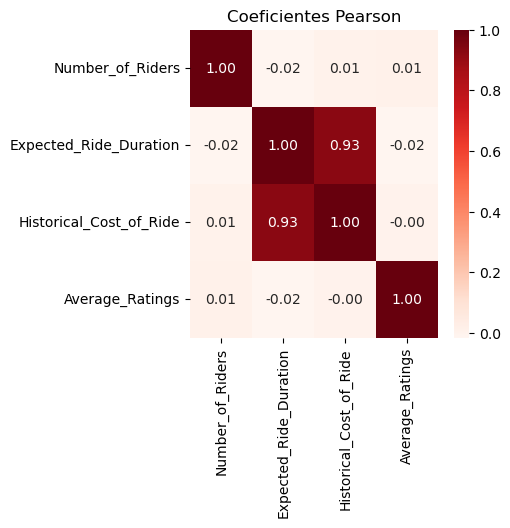

In [43]:
heatmap(corr, "Coeficientes Pearson")

### Valores P de las pruebas estadiscas de correlación

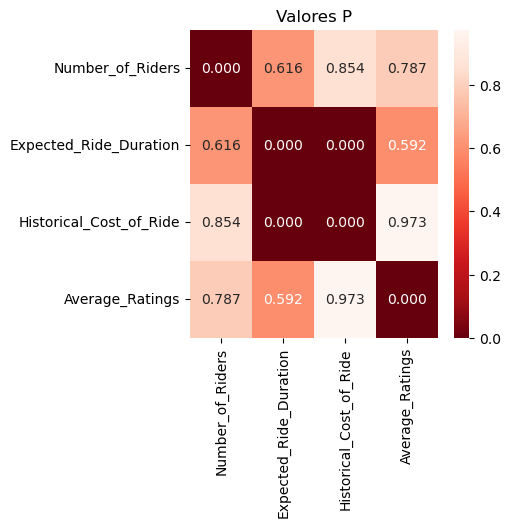

In [42]:
heatmap(valores_p, "Valores P", formato=".3f", mapa="Reds_r")

### Analisis Sobre las correlaciones:

El primer mapa de calor muestra los resultados del test de pearson. Se observa que solo se obtuvo un valor alto 
y cercano a 1 entre las variables de **costo historico del viaje** y **duración esperada del viaje** con un valor de $r= 0.93$. Esto sugiere que la relacion es fuertemente lineal en este emparejamiento. 

En los demas pares, **costo historico del viaje** vs. **Cantidad de Pasajeros** y **duración esperada del viaje** vs. **Cantidad de Pasajeros**, se observan valores de *r* casi nulos. Esto implica que no tienen correlacion lineal, pero no descarta que puedan tener algún otro tipo de correlación. 

Para comprobar estas relaciones se recurre al calculo de valores *P*. Para esto hay que tener en cuenta cuales hipotesis se estan usando:
$$ H_0: \rho = 0 $$
$$ H_1: \rho \neq 0 $$

donde $\rho$ es el coeficiente de pearson de la población. Lo que significa la hipotesis nula es que las varaibles no tienen una correlación lineal, y estan distribuidos normalmente en la población.

El segundo mapa de calor esta alterado para que valores bajos tengan una coloración mas intensa; y se puede observar que el valor mas bajo de $P = 0.00$ se da precisamente entre **costo historico del viaje** y **duración esperada del viaje**. En este caso, se rechaza la hipotesis nula, y se concluye que hay una alta posibilidad de que ambas tengan una correlación lineal fuerte.

Para los otros tres pares, se encuentra que los valores *P* son: 

**Costo historico del viaje** vs. **Cantidad de Pasajeros**: $p = 0.854$

**Duración esperada del viaje** vs. **Cantidad de Pasajeros**: $p = 0.616$ 

**Costo historico del viaje** vs. **Puntaje Promedio**: $p = 0.973$ 

Los valores altos y mayores que 0.05 sugieren aceptar la hipotesis nula, y aceptar que los pares de variables no tienen correlacion lineal, y posiblimente no tienen correlación en la población. 


## 3. Tablas de Contingencia Y Pruebas Chi-Cuadrado

El siguiente fragmento de codigo calcula las tablas de contingencia para las combinaciones de tres variables dadas, y realiza un prueba de chi-cuadrado entre las variables,
con el proposito de comprobar la significancia estadistica de las proporciones/mayorias en las tablaso de contingencia.

In [17]:
def tabla_contingencia(datos, factores, relativa=False):
    """
    Construir una tabla de contingencia.
    """
    f1, f2 = factores
    
    tabla = pd.crosstab(datos[f1], datos[f2],  margins=True)

    if relativa:
        for campo in tabla.columns[:-1]:
            tabla[campo] /= tabla[campo].iloc[-1]

        tabla["All"] /= tabla["All"]

    return tabla

def test_chi_cuadrado(datos):
    """
    crea un dataframe, con las filas siendo los totales de las columnas, duplicado
    la cantidad de filas de los datos
    """
    
    totales_por_columna_aumentado = pd.DataFrame([datos.iloc[-1,:-1].values]*(datos.shape[0] - 1))

    probabilidad_positiva= datos.iloc[:-1,-1].values / datos.iloc[-1,-1] 

    #calculo de la frecuencias esperadas, multiplicando la probabilidad del 
    #evento positivo por el total de columna, por cada fila
    frec_esp = totales_por_columna_aumentado.mul(probabilidad_positiva, axis=0)

    #delta de los grados de libertad para el chi cuadrado
    ddof = sum(frec_esp.shape) - 2

    gl = (frec_esp.shape[0] - 1) * (frec_esp.shape[1] - 1)

    #el parametro axis, hace que las frecuencias se tomen como si fuera un vector
    return chisquare(datos.iloc[:-1, :-1], f_exp=frec_esp, ddof=ddof, axis=None), gl

def mostrar_chi(resultados):
    """
    mostrar un pequeño resumen de los
    resultados de un prueba chi-cuadrado
    """
    test, gl = resultados

    print(f"Chi Cuadrado    : {test.statistic:.3f}")
    
    print(f"Valor P         : {test.pvalue:.3f}")
    
    print(f"Grados libertad : {gl}")
    
  

### Prueba de Chi-Cuadrado

La prueba de chi-cuadrado se usa regularmente en contextos donde se desea ver si hay alguna relación entre dos variables categoricas, tomando en cuenta las proporciones entre sus categorias.
Se desea saber si dos variables son o no independientes entre si, con los datos dados. Esta pregunta se puede expresar naturalmente con la probablidad, creando la siguiente hipotesis nula:

$$ H_0: P(X_1|Y_1) = P(X_1|Y_2) = P(X_1|Y_3) ... = P(X_1|Y_n)$$
$$ H_1: \neg (P(X_1|Y_1) = P(X_1|Y_2) = P(X_1|Y_3) ... = P(X_1|Y_n)) $$

En las formulas, $P$ indica probablidad condicional, $X$ es una de las variables, y $Y$ es la segunda de ellas. Lo que la hipotesis nula esta indicando, es que la probabilidad de que la variable $X$ tome un valor especifico sera la misma sin importar que valor tenga la variable $Y$. La hipotesis alternativa indica que que las probabilidades son diferentes por lo menos para algun valor de la variable $X$, y alguno de la variable $Y$.

### Lealtad del Cliente vs. Hora de Agendar 

In [25]:
tabla_1 = tabla_contingencia(df_modelos, (Categ.tiempo_viaje.value, Categ.lealtad.value ))

display(tabla_1)

Customer_Loyalty_Status,Gold,Regular,Silver,All
Time_of_Booking,,,,
Afternoon,68,89,90,247
Evening,76,74,81,231
Morning,79,79,88,246
Night,90,78,108,276
All,313,320,367,1000


#### Por Proporciones:

In [19]:
tabla_1_p = tabla_contingencia(df_modelos, (Categ.tiempo_viaje.value, Categ.lealtad.value ), relativa=True)

display(tabla_1_p)

Customer_Loyalty_Status,Gold,Regular,Silver,All
Time_of_Booking,,,,
Afternoon,0.217,0.278,0.245,1.000
Evening,0.243,0.231,0.221,1.000
Morning,0.252,0.247,0.240,1.000
Night,0.288,0.244,0.294,1.000
All,1.000,1.000,1.000,1.000


In [99]:
mostrar_chi(test_chi_cuadrado(tabla_1))

Chi Cuadrado    : 4.650
Valor P         : 0.589
Grados libertad : 6


#### Analisis:

La tabla de contingencia muestra que en las horas de la mañana y de la noche es donde se presentan la mayor cantidad de solicitudes para el servicio de transporte, en los grupos de oro y plata, mientras que en el grupo regular sucede en las horas de la mañana y tarde. 

Esto se podria explicar por la gran afluencia de personas que se deben desplazar para trabajar en la mañana, y volver en la noche, que intuitivamente seria mayor que las que se desplazan en la tarde o al anochecer, y no necesariamente tendria que ver con el clase de lealtad del cliente.

la prueba de chi-cuadrado nos mostraria si hay alguna significancia en estas diferencias. El resultado del valor $P = 0.59$ equivalente para la prueba es muy superior al critico de *0.05*,
indicando que hay gran probalidad para que se de la hipotesis nula: no habria evidencia para afirmar que algun grupo solicite de forma diferencial en ciertas horas del dia, sobre los otros. 

### Lealtad del Cliente vs. Tipo de Vehiculo 

In [21]:
tabla_2 = tabla_contingencia(df_modelos, (Categ.vehiculo.value, Categ.lealtad.value))

display(tabla_2)

Customer_Loyalty_Status,Gold,Regular,Silver,All
Vehicle_Type,,,,
Economy,153,144,181,478
Premium,160,176,186,522
All,313,320,367,1000


#### Por Proporciones:

In [20]:
tabla_2_p = tabla_contingencia(df_modelos, (Categ.vehiculo.value, Categ.lealtad.value), relativa=True)

display(tabla_2_p)

Customer_Loyalty_Status,Gold,Regular,Silver,All
Vehicle_Type,,,,
Economy,0.489,0.450,0.493,1.000
Premium,0.511,0.550,0.507,1.000
All,1.000,1.000,1.000,1.000


In [86]:
mostrar_chi(test_chi_cuadrado(tabla_2))

Chi Cuadrado    : 1.492
Valor P         : 0.474
Grados libertad : 2


#### Analisis:

Observando los tres grupos, se observa que en los tres grupo de lealtad se solicitan mas vehiculos de clase premium, donde la clase regular tiene la mayoria con un  $55\%$. Estos datos reflejarian que los vehiculos de tipo premium son en general mejores que los economicos, y la preferencia obedezca a otros factores diferentes de la lealtad.

la Pruba de chi-cuadrado obtuvo un valor de $P=0.47$, y en este caso tambien da positiva para la hipotesis nula: los datos proporcionados no dan suficiente evidencia para afirmar que pertenecer a cierto grupo de lealtad implique preferir alguna de las clases del vehiculo.

### Hora de Agendar vs. Tipo de Vehiculo

In [22]:
tabla_3 = tabla_contingencia(df_modelos, (Categ.tiempo_viaje.value, Categ.vehiculo.value))

display(tabla_3)

Vehicle_Type,Economy,Premium,All
Time_of_Booking,,,
Afternoon,123,124,247
Evening,98,133,231
Morning,121,125,246
Night,136,140,276
All,478,522,1000


#### Por Proporciones:

In [23]:
tabla_2_p = tabla_contingencia(df_modelos, (Categ.tiempo_viaje.value, Categ.vehiculo.value), relativa=True)

display(tabla_2_p)

Vehicle_Type,Economy,Premium,All
Time_of_Booking,,,
Afternoon,0.257,0.238,1.000
Evening,0.205,0.255,1.000
Morning,0.253,0.239,1.000
Night,0.285,0.268,1.000
All,1.000,1.000,1.000


#### Variables invertidas:


In [24]:
tabla_2_p = tabla_contingencia(df_modelos, ( Categ.vehiculo.value, Categ.tiempo_viaje.value), relativa=True)

display(tabla_2_p)

Time_of_Booking,Afternoon,Evening,Morning,Night,All
Vehicle_Type,,,,,
Economy,0.498,0.424,0.492,0.493,1.000
Premium,0.502,0.576,0.508,0.507,1.000
All,1.000,1.000,1.000,1.000,1.000


In [102]:
mostrar_chi(test_chi_cuadrado(tabla_3))

Chi Cuadrado    : 3.501
Valor P         : 0.321
Grados libertad : 3


#### Analisis:

En este caso, se hicieron dos tablas de contingencia de proporciones, con las variables invertidas. En la primera se observa que en la noche se piden la mayor cantidad de viajes en cualquiera de las 
categorias de vehiculo con porcentajes de $28.45\%$ para la economica, y $26.81\%$ para la premium. La otra tabla revela que en, todas la franjas de tiempo, se pide mas la categoria premium que la regular, superando o igualando el $50\%$ en todos los casos. Esto podria reflejar que en la noche el trafico en grande, posiblemente por el flujo de personas regresando, aunque se necesitaria mas contexto. 

La relación entre la hora de la solicitud y el tipo de vehiculo seria menos clara, la mayoria de los vehiculos premium podria deberse a otros factores diferentes. la prueba chi-cuadrado muesta un $P = 0.321$, que indica que se debe aceptar la hipotesis nula: No parece haber relación entre las dos variables.

## 4. Pruebas ANOVA

Para poder realizar el analisis de medias entre las diferentes grupos de lealtad y las variables numericas dadas, se agrupó el conjunto de datos con el metodo `groupby` de los dataframes de pandas. Este objeto es el `grupos_lealtad` de la siguiente celda.

En los siguientes calculos, se consigue el campo correspondiente a la variable numerica en estudio, se visualizan por medio de un grafico de cajas y bigotes, y se les realiza un prueba de ANOVA de una unica variable, comprobando si existen diferencias significativas entre las variables.

Para tres pruebas se tienen las siguientes hipotesis: 

$$ H_0: \mu_{gold} = \mu_{silver} = \mu_{regular} $$
$$ H_1: \neg (\mu_{gold} = \mu_{silver} = \mu_{regular} ) $$

La hipotesis nula indica que que no hay diferencias significativas entre las medias de los grupos, y la hipotesis alternativa indica que puede haber diferencia entre las medias de  todos los grupos, o al menos entre dos de ellos.



In [107]:
def mostrar_anova(resultados):
    """
    mostrar un pequeño resumen de los
    resultados de un prueba ANOVA
    """

    print(f"Valor F: {resultados.statistic:.3f}")
    
    print(f"Valor P: {resultados.pvalue:.3f}")
    
 
grupos_lealtad = df_modelos.groupby([Categ.lealtad.value])

### Puntaje Promedio vs. Lealtad del Cliente

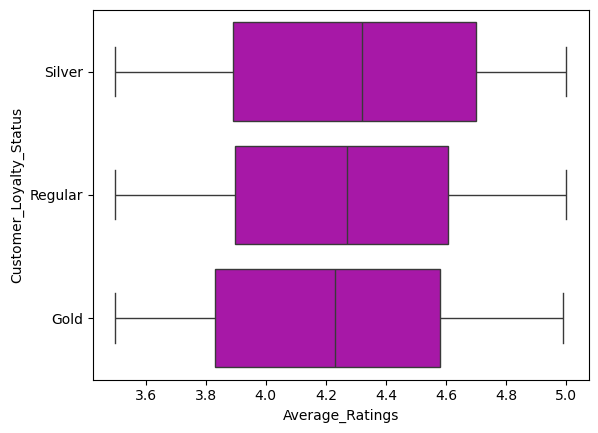

In [225]:
sns.boxplot(data=df_modelos, x=Num.puntaje_promedio.value, y=Categ.lealtad.value, color="m")
plt.show()

In [108]:
muestras_puntaje = grupos_lealtad[Num.puntaje_promedio.value].apply(np.array)
display(muestras_puntaje)
resultados = f_oneway(*muestras_puntaje) 
mostrar_anova(resultados)

Customer_Loyalty_Status
Gold       [3.59, 4.14, 4.12, 4.31, 3.81, 4.39, 4.79, 4.6...
Regular    [4.31, 3.77, 4.41, 4.69, 4.95, 4.95, 3.97, 3.6...
Silver     [4.47, 4.06, 3.99, 3.51, 3.74, 3.85, 4.22, 4.5...
Name: Average_Ratings, dtype: object

Valor F: 2.314
Valor P: 0.099


#### Interpretación Caja de bigotes:

Los graficos de caja para los tres grupos se ven similares, y la mediana de los tres se acercan al mismo valor de $4.3$. La caja de la categoría de plata es más ancha, mostrando mas variabilidad en los grupos, y el grupo regular me el de menos variabilidad. Esto mostraráa que la calidad de los viajes es casi la misma a traves de los diferentes grupos de lealtad. Adicionalmente, no se observan outliers en ninguno de los grupos, y se observa una distribución similar sin considerar la separación por grupos, indicando que los datos estan bien distribuidos. No se considera que haya diferencias significativas.


#### ANOVA

el resultado del estadistico valor $P = 0.099$ en este caso es muy ceracano al limite 0.05. Usando estrictamente la prueba, se deberia concluir que no hay evidencia suficiente de significancia estadistica, y se acepta la hipotesis nula. Los tres grupos tendrian sus calificaciones repartidos de forma normal, y aleatoria, y no habria efecto por la clase de lealtad. En otras palabras, la pertenencia a alguno de las clases altas no hace que se favorezca más, ni menos, la calificación del servicio, respecto al grupo de regulares.


### Numero de Pasajeros vs. Lealtad del Cliente

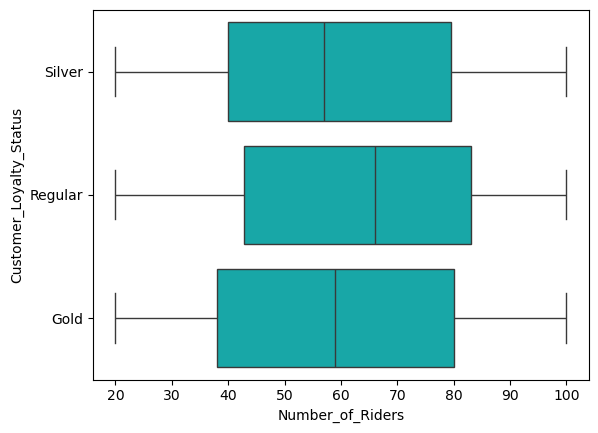

In [223]:
sns.boxplot(data=df_modelos, x=Num.pasajeros.value, y=Categ.lealtad.value, color="c")
plt.show()

In [109]:
muestras_pasajeros = grupos_lealtad[Num.pasajeros.value].apply(np.array)
display(muestras_pasajeros)
resultados = f_oneway(*muestras_pasajeros) 
mostrar_anova(resultados)

Customer_Loyalty_Status
Gold       [62, 60, 24, 33, 48, 72, 75, 39, 35, 28, 25, 6...
Regular    [89, 78, 93, 86, 63, 96, 74, 24, 56, 62, 68, 2...
Silver     [90, 58, 42, 59, 79, 42, 36, 39, 38, 46, 31, 2...
Name: Number_of_Riders, dtype: object

Valor F: 2.384
Valor P: 0.093


#### Interpretación Caja de bigotes:

En la comparación de ambas variables, Las cajas de bigotes se ven similares, y la mediana de los grupos oro y plata se acercan al mismo valor de $59$. Las cajas del grupo plata y regular estan algo sesgadas, hacia la derecha e izquierda respectivamente respecto de la caja simetrica del oro. Sin embargo, estas diferencias no son suficientes para suponer alguna diferencia signficativa en la cantidad de pasajeros sobre los otros grupos. Los tres grupos parecen tener el mismo nivel de dispersión de los datos

#### ANOVA

El resultado de la prueba dio con un valor $P=0.093$. Este valor esta muy cerca del limite de $0.05$, pero esta por encima. Se concluye que hay suficiente evidencia para rechazar la hipotesis alternativa:
no se observan diferencias significativas entre las medias de los grupos, y no se pueden concluir que afecten a la cantidad de pasajeros solicitando en el area.

### Duración del Viaje vs. Lealtad del Cliente

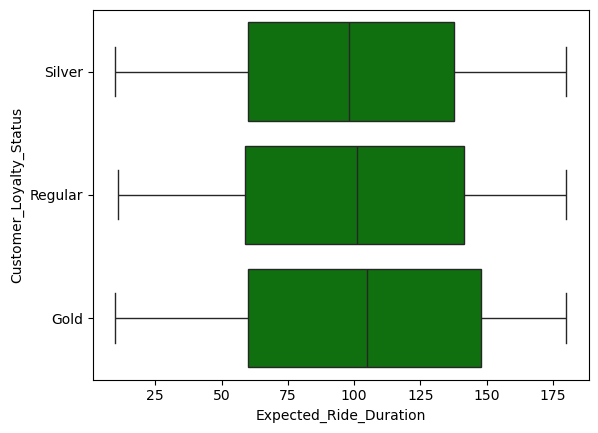

In [228]:
sns.boxplot(data=df_modelos, x=Num.duracion_esperada.value, y=Categ.lealtad.value, color="g")
plt.show()

In [111]:
muestras_duracion = grupos_lealtad[Num.duracion_esperada.value].apply(np.array)
display(muestras_duracion)
resultados = f_oneway(*muestras_duracion) 
mostrar_anova(resultados)

Customer_Loyalty_Status
Gold       [47, 144, 164, 22, 65, 30, 153, 48, 105, 94, 1...
Regular    [134, 149, 16, 167, 102, 11, 139, 45, 162, 129...
Silver     [90, 43, 76, 128, 128, 128, 83, 140, 54, 15, 8...
Name: Expected_Ride_Duration, dtype: object

Valor F: 0.828
Valor P: 0.437


#### Interpretación Caja de bigotes:

Las cajas de bigotes se ven muy similars entre si, las medianas casi se alinean alrededor de $100$ minutos, y todas las cajas se ven simetricas. El grupo de la lealtad de oro tiene una caja algo mas grande, mostrando una variabilidad algo mayor. Los datos se ven distribuidos normalmente en los grupos regular y de plata, y parecen sesgados hacia valores altos en el grupo de oro. Estas diferencias apuntan a que las duraciones estan distribuidas de forma similar entre grupos, y que la clase de lealtad no es un factor que afecte la duración.

#### ANOVA

El valor de la prueba da un valor de $P = 0.437$, que esta muy por encima del limite de $0.05$. Se puede concluir con seguridad que no hay relación entre la duración esperada del viaje
y la clase de lealtad de los clientes. La duración debe variar respecto a otros factores.

## Conclusiones

### Analisis Unidimensional

- Entre las variables categoricas las modas fueron: la noche para la hora de agendamiento, la clase plata para la lealtad del cliente, la zona urbana para la locación, y se piden mayoritarimente vehiculos premium. Por parte de las numericas:

   > - La cantidad esperada de pasajeros esperando el servico es de $60$.
   > - Las calificaciones varian entre $3.5$ - $5.0$, siendo la calificación esperada de $4.25$. Esto indica que los clientes piensan que el servicio va desde mediocre a muy bueno.
   > - La duración esperada estadisticamente es de $1$ hora, $39$ min.
   > - El costo esperado del viaje es de $372$. 

- En general, en todas las variables categoricas se encontro que las frecuencias de sus valores eran muy similares, causando proporciones que se asemejan a lo esperado por la probabilidad. Todas las variables numericas, tomadas individualmente tienen una distribución normal o muy cercana a la normal. La unica variable donde se vio una desviación fue en el costo historico del viaje.

### Analisis Bidimensional

- Se encontro una relación lineal fuerte entre las variables del *costo historico del viaje*, y *Duración esperada del viaje*, la cual se comprobó despues mediante una prueba de correlación entre variables. Esta relación corresponde al uso de la duración del viajes para controlar actualmente el costo de los viajes, en la estrategia de precios dinamicos.

- No se encontraron otras relaciones relevantes entre los emparejamientos del *Cantidad de Pasajeros* vs. *Costo historico*, y la *Calificación de lo viajes* vs. *Costo historico de los viajes*. Esta ausencia se comprobó mediante pruebas de correlación. En un principio, tiene sentido que no haya relación, debido a que no se usan como entradas para el modelo de precios. La cantidad de pasajeros en el area deberia incluirse, ya que representa la demanda como tal del servicio, y esta deberia influir en el costo del servicio.

### Analisis Inferencial

- No se encontraron relaciones significativas entre variables en las pruebas de chi-cuadrado. Las proporciones que se hallaron significativas en
las tablas siguen las mismas tendencias que evaluando las variables por separado, y parece que los valores de la *Clase de Lealtad* no afecta las proporciones de las variables numericas evaluadas.

- No se encontraron relaciones entre las variables numericas y las categoricas. Ni las cajas de bigotes mostraron relaciones significativas,
ni las pruebas ANOVA mostraron evidencia suficiente para afirmar diferencias significativas enter medias. Sin embargo, las variables *Cantidad de Pasajeros* y *Calificacion del servicio* tenian valores $P$ muy cercanos al limite critico de $0.05$. Esto lleva a pensar que con mayor cantidad de datos, se podria encontrar evidencia para posibles relaciones, y que posiblemente sean adecuadas para la inclusión en el modelo de precios.

## Enlace Sustentación:

## [Diapositivas](https://view.genially.com/66ff75d99b2ca5d6ff5c8ab3/presentation-informe-precios-dinamicos)

## [Presentación](https://youtu.be/2kUlvPQi5dU)

# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.

- Samuels, M., Witmer, J., & Shaffner, A. (2012). Fundamentos de Estadística Para Las Ciencias de la Vida (4th ed.). Pearson.

